In [ ]:

from __future__ import annotations
import random, pathlib, json
from collections import Counter
from types import SimpleNamespace

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# --------------------------- network construction ----------------------------
def build_layers(L:int, *, P_REWIRE=0.01, K_BLUE=4, M0_RED=4, M_RED=2,
                 periodic:bool=True, rng:random.Random) -> tuple[nx.Graph,dict]:
    N = L * L
    grid = nx.grid_2d_graph(L, L, periodic=periodic)
    grid = nx.relabel_nodes(grid, {n:i for i,n in enumerate(grid.nodes())})
    pos  = {i:(i%L, i//L) for i in range(N)}

    # blue (WS)
    E_target = N*K_BLUE//2
    blue = grid.copy()
    for u,v in list(grid.edges()):
        if rng.random() < P_REWIRE:
            blue.remove_edge(u,v)
            while True:
                w = rng.randrange(N)
                if w!=u and not blue.has_edge(u,w):
                    blue.add_edge(u,w); break
    while blue.number_of_edges() < E_target:
        u,v = rng.sample(range(N),2)
        if not blue.has_edge(u,v): blue.add_edge(u,v)
    while blue.number_of_edges() > E_target:
        blue.remove_edge(*rng.choice(list(blue.edges())))

    # red (BA)
    red = nx.Graph(); red.add_nodes_from(range(N))
    init = rng.sample(range(N), M0_RED)
    for i in range(M0_RED):
        for j in range(i+1, M0_RED):
            red.add_edge(init[i], init[j])
    targets = list(init)
    for new in range(N):
        if new in init: continue
        chosen=set()
        while len(chosen) < M_RED:
            t = rng.choice(targets)
            if t!=new: chosen.add(t)
        for t in chosen: red.add_edge(new,t)
        targets.extend([new]*M_RED)

    # merge with color
    G = nx.Graph(); G.add_nodes_from(range(N))
    for u,v in blue.edges(): G.add_edge(u,v,color='blue')
    for u,v in red.edges():
        if G.has_edge(u,v): G[u][v]['color']='mixed'
        else:               G.add_edge(u,v,color='red')
    return G, pos

# ------------------------------ one realisation ------------------------------
def simulate_once(seed:int, *, beta_T:float, beta_F:float,
                  G_template:nx.Graph|None=None, pos:dict|None=None,
                  L:int=32, P_REWIRE=0.05, K_BLUE=6, M0_RED=4, M_RED=3,
                  max_steps:int=12_000, force_finish:bool=False):
    rng = random.Random(seed)

    if G_template is None:
        G,pos = build_layers(L, P_REWIRE=P_REWIRE, K_BLUE=K_BLUE,
                             M0_RED=M0_RED, M_RED=M_RED, rng=rng)
    else:
        G,pos = G_template, pos

    N = len(G)
    state = {n:'S' for n in G}
    pt_T, pt_F = rng.sample(range(N),2)
    state[pt_T]='T'; state[pt_F]='F'

    beta_map = {'blue':(beta_T,beta_F), 'red':(beta_T,beta_F), 'mixed':(beta_T,beta_F)}

    def count_S_T_F():
        c = Counter(state.values()); return c['S'],c['T'],c['F']

    S,T,F = count_S_T_F(); step=0
    cap = float('inf') if force_finish else max_steps
    while S>0 and step<cap:
        step += 1
        u,v = rng.choice(list(G.edges()))
        bT,bF = beta_map[G[u][v]['color']]
        if state[u]=='T' and state[v]=='S' and rng.random()<bT:
            state[v]='T'; S-=1; T+=1
        elif state[v]=='T' and state[u]=='S' and rng.random()<bT:
            state[u]='T'; S-=1; T+=1
        if state[u]=='F' and state[v]=='S' and rng.random()<bF:
            state[v]='F'; S-=1; F+=1
        elif state[v]=='F' and state[u]=='S' and rng.random()<bF:
            state[u]='F'; S-=1; F+=1

    deg_T = G.degree(pt_T); deg_F = G.degree(pt_F)
    cl_T  = nx.clustering(G, pt_T); cl_F = nx.clustering(G, pt_F)
    dist_TF = nx.shortest_path_length(G, pt_T, pt_F)

    return dict(T=T, F=F,
                deg_T=deg_T, deg_F=deg_F,
                cl_T=cl_T, cl_F=cl_F,
                dist=dist_TF,
                finished=(S==0))

# -------------------------------- batch driver -------------------------------
def make_cfg(**kwargs):
    d = dict(runs=300, L=32,
             beta_T=0.30, beta_F=0.30,
             prewire=0.05, kblue=6, m0red=4, mred=3,
             maxsteps=12_000, seed=12345,
             outdir='batch_outputs', show=True,
             fixednet=True, force_finish=False)
    d.update(kwargs)
    return SimpleNamespace(**d)

def run_batch(cfg):
    outroot = pathlib.Path(cfg.outdir); outroot.mkdir(exist_ok=True)

    # build ONCE if fixednet=True (reused across all runs)
    fixedG, fixedPos = (None, None)
    if cfg.fixednet:
        base_seed = cfg.seed if cfg.seed is not None else random.randrange(2**32)
        fixedG, fixedPos = build_layers(cfg.L,
                                        P_REWIRE=cfg.prewire, K_BLUE=cfg.kblue,
                                        M0_RED=cfg.m0red, M_RED=cfg.mred,
                                        rng=random.Random(base_seed))

    results=[]
    for i in range(cfg.runs):
        seed = (cfg.seed or random.randrange(2**32)) + i
        res = simulate_once(seed,
                            beta_T=cfg.beta_T, beta_F=cfg.beta_F,
                            G_template=fixedG, pos=fixedPos,
                            L=cfg.L, P_REWIRE=cfg.prewire, K_BLUE=cfg.kblue,
                            M0_RED=cfg.m0red, M_RED=cfg.mred,
                            max_steps=cfg.maxsteps, force_finish=cfg.force_finish)
        results.append(res)
        if (i+1) % max(1, cfg.runs//10) == 0:
            print(f" · {i+1}/{cfg.runs} runs done", flush=True)

    # arrays
    N      = cfg.L * cfg.L
    T_all  = np.array([r['T'] for r in results])
    F_all  = np.array([r['F'] for r in results])
    done   = np.array([r['finished'] for r in results], dtype=bool)

    n_finished   = int(done.sum())
    n_unfinished = int((~done).sum())
    if n_unfinished and not cfg.force_finish:
        print(f" ⚠ {n_unfinished}/{cfg.runs} runs hit max_steps before S=0.")

    # use finished runs if we have >=2; else fall back to all runs
    if n_finished >= 2:
        idx = done
        print(f" Using {n_finished} finished runs for plots/statistics.")
    else:
        idx = np.ones_like(done, dtype=bool)
        if not cfg.force_finish:
            print(" ⚠ Not enough finished runs → using ALL runs (T+F may be < N).")

    T = T_all[idx]
    F = F_all[idx]
    D = T - F

    deg_diff = np.array([r['deg_T']-r['deg_F'] for r in results])[idx]
    cl_diff  = np.array([r['cl_T'] -r['cl_F'] for r in results])[idx]
    dist_tf  = np.array([r['dist']              for r in results])[idx]

    # safe correlations
    def safe_corr(x, y):
        x = np.asarray(x); y = np.asarray(y)
        if x.size < 2 or y.size < 2:
            return float('nan'), float('nan')
        try:  r  = float(pearsonr(x, y)[0])
        except Exception: r = float('nan')
        try:  rs = float(spearmanr(x, y)[0])
        except Exception: rs = float('nan')
        return r, rs
    
    def hist_prob_with_mean(ax, data, color, title, xlabel, nbins='auto'):
        if data.size == 0:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('probability')
            return np.array([]), np.array([])
        # bars represent probabilities that sum to 1
        weights = np.ones_like(data, dtype=float) / data.size
        # compute *edges* first (allowed even with weights)
        edges = np.histogram_bin_edges(data, bins=nbins)  # ← key change
        vals, bins, _ = ax.hist(
            data, bins=edges, weights=weights, alpha=0.8,
            color=color, edgecolor='none'
        )
        m = float(np.mean(data))
        ax.axvline(m, color='k', ls='--', lw=1)
        ax.annotate(f'{m:.1f}', xy=(m, vals.max()*1.05), xytext=(0,0),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('probability')
        return vals, bins



    # ------------------------------ FIGURE 1 ---------------------------------
    fig,axs = plt.subplots(2,2, figsize=(12,10))

    def hist_with_mean(ax, data, color, title):
        if data.size == 0:
            ax.text(0.5,0.5,'no data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title); return
        vals, bins, _ = ax.hist(data, bins='auto', density=True, alpha=0.8, color=color)
        m = float(np.mean(data))
        ax.axvline(m, color='k', ls='--', lw=1)
        ax.annotate(f'{m:.1f}', xy=(m, vals.max()*1.03), xytext=(0,0),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
        ax.set_title(title); ax.set_xlabel('# nodes'); ax.set_ylabel('density')

    hist_prob_with_mean(axs[0,0], T, '#2ca02c', 'Final T-nodes (green)', '# nodes')
    hist_prob_with_mean(axs[0,1], F, '#e41a1c', 'Final F-nodes (red)',   '# nodes')


    # 2) Dominance Δ = T − F  (who wins & by how much)
    if D.size:
        weights_D = np.ones_like(D, dtype=float) / D.size
        edges_D   = np.histogram_bin_edges(D, bins='auto')  # ← precompute edges
        vals_D, bins_D, _ = axs[1,0].hist(
            D, bins=edges_D, weights=weights_D,
            color='#bdbdbd', alpha=0.9, edgecolor='none'
        )
        axs[1,0].axvline(0, color='k', lw=1)
        axs[1,0].set_title('Dominance Δ = T − F')
        axs[1,0].set_xlabel('Δ  (positive → T wins)')
        axs[1,0].set_ylabel('probability')

        # put win labels at data edges (left=F, right=T)
        xL, xR  = float(D.min()), float(D.max())
        yTop    = float(vals_D.max()) * 1.05
        axs[1,0].annotate(f'F wins {(D<0).mean()*100:.1f}%',
                        xy=(xL, yTop), xytext=(0,0), textcoords='offset points',
                        ha='left', va='bottom')
        axs[1,0].annotate(f'T wins {(D>0).mean()*100:.1f}%',
                        xy=(xR, yTop), xytext=(0,0), textcoords='offset points',
                        ha='right', va='bottom')
    else:
        axs[1,0].text(0.5,0.5,'no data', ha='center', va='center',
                    transform=axs[1,0].transAxes)




    # dot plot (T green, F red)
    run_idx = np.arange(T.size)
    axs[1,1].scatter(run_idx, T, s=9, alpha=0.75, color='#2ca02c', label='T')
    axs[1,1].scatter(run_idx, F, s=9, alpha=0.75, color='#e41a1c', label='F')
    axs[1,1].axhline(N/2, color='k', lw=0.8, ls=':')
    axs[1,1].set_title('Final counts per run')
    axs[1,1].set_xlabel('run index'); axs[1,1].set_ylabel('# nodes')
    axs[1,1].legend(loc='best', frameon=False)

    plt.tight_layout()
    fig.savefig(outroot / f"summary_plots_{cfg.runs}runs.png", dpi=300)
    if cfg.show:
        plt.show()
    plt.close(fig)

    # --- helpers for binned lines ---
    def _bin_means(x, y, nbins=8):
        x = np.asarray(x); y = np.asarray(y)
        if x.size == 0 or y.size == 0:
            return np.array([]), np.array([])
        edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
        mids  = 0.5*(edges[:-1] + edges[1:])
        idx   = np.digitize(x, edges[1:-1])  # 0..nbins-1
        means = np.full(nbins, np.nan)
        for k in range(nbins):
            sel = (idx == k)
            if np.any(sel):
                means[k] = np.nanmean(y[sel])
        return mids, means

    def _bin_winprob(x, d, nbins=8):
        # probability T wins (Δ>0) in each x-bin
        x = np.asarray(x); d = np.asarray(d)
        if x.size == 0 or d.size == 0:
            return np.array([]), np.array([])
        edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
        mids  = 0.5*(edges[:-1] + edges[1:])
        idx   = np.digitize(x, edges[1:-1])
        p     = np.full(nbins, np.nan)
        for k in range(nbins):
            sel = (idx == k)
            if np.any(sel):
                p[k] = np.mean(d[sel] > 0)
        return mids, p

    # --------------------------- FIGURE 2: seed effects ----------------------
    fig2, ax2 = plt.subplots(1, 3, figsize=(15, 4))
    for i, (arr, label) in enumerate([(deg_diff,'Δ degree'),
                                      (cl_diff,'Δ clustering'),
                                      (dist_tf,'d(T,F)')]):
        ax2[i].scatter(arr, D, s=12, alpha=0.6)
        xm, ym = _bin_means(arr, D, nbins=8)
        

        r, _  = pearsonr(arr, D)
        rs, _ = spearmanr(arr, D)
        ax2[i].set_xlabel(label)
        if i == 0:
            ax2[i].set_ylabel('Δ = T – F')
        ax2[i].set_title(f'{label} vs Δ\nPearson r={r:.2f}, ρ={rs:.2f}')

    plt.tight_layout()
    fig2.savefig(outroot / f"seed_effects_{cfg.runs}runs.png", dpi=300)
    if cfg.show:
        plt.show()
    plt.close(fig2)

    ## FIGURE 3
    # ───────────────────────── FIGURE 3: win probability curves ─────────────────
    fig3, ax3 = plt.subplots(1, 3, figsize=(15, 4))
    for i, (arr, label) in enumerate([(deg_diff,'Δ degree'),
                                      (cl_diff,'Δ clustering'),
                                      (dist_tf,'d(T,F)')]):
        xm, p = _bin_winprob(arr, D, nbins=8)
        ax3[i].plot(xm, p, marker='o')
        ax3[i].axhline(0.5, color='k', ls=':', lw=1)
        ax3[i].set_ylim(0, 1)
        ax3[i].set_xlabel(label)
        if i == 0:
            ax3[i].set_ylabel('P(T wins)')
        ax3[i].set_title(f'Win probability vs {label}')
    plt.tight_layout()
    fig3.savefig(outroot / f"winprob_{cfg.runs}runs.png", dpi=300)
    if cfg.show:
        plt.show()
    plt.close(fig3)



    # JSON summary (matching the plotted subset)
    pear_deg, _   = safe_corr(deg_diff, D)
    pear_clust, _ = safe_corr(cl_diff,  D)
    pear_dist, _  = safe_corr(dist_tf,  D)

    with open(outroot / f"summary_{cfg.runs}runs.json", "w") as fh:
        json.dump({
            "runs": cfg.runs, "L": cfg.L,
            "beta_T": cfg.beta_T, "beta_F": cfg.beta_F,
            "finished_runs": int(done.sum()),
            "unfinished_runs": int((~done).sum()),
            "used_finished_subset": bool(n_finished >= 2),
            "mean_T": float(np.mean(T)) if T.size else None,
            "std_T":  float(np.std(T, ddof=1)) if T.size>1 else None,
            "mean_F": float(np.mean(F)) if F.size else None,
            "std_F":  float(np.std(F, ddof=1)) if F.size>1 else None,
            "pearson_deg": pear_deg,
            "pearson_cl":  pear_clust,
            "pearson_dist": pear_dist,
        }, fh, indent=2)
    for num in plt.get_fignums():
        fig = plt.figure(num)
        fig.savefig(outroot / f"figure_{num}_{cfg.runs}runs.png", dpi=300)
    print("Finished – results in", outroot.resolve())


 · 100/1000 runs done
 · 200/1000 runs done
 · 300/1000 runs done
 · 400/1000 runs done
 · 500/1000 runs done
 · 600/1000 runs done
 · 700/1000 runs done
 · 800/1000 runs done
 · 900/1000 runs done
 · 1000/1000 runs done
 Using 1000 finished runs for plots/statistics.


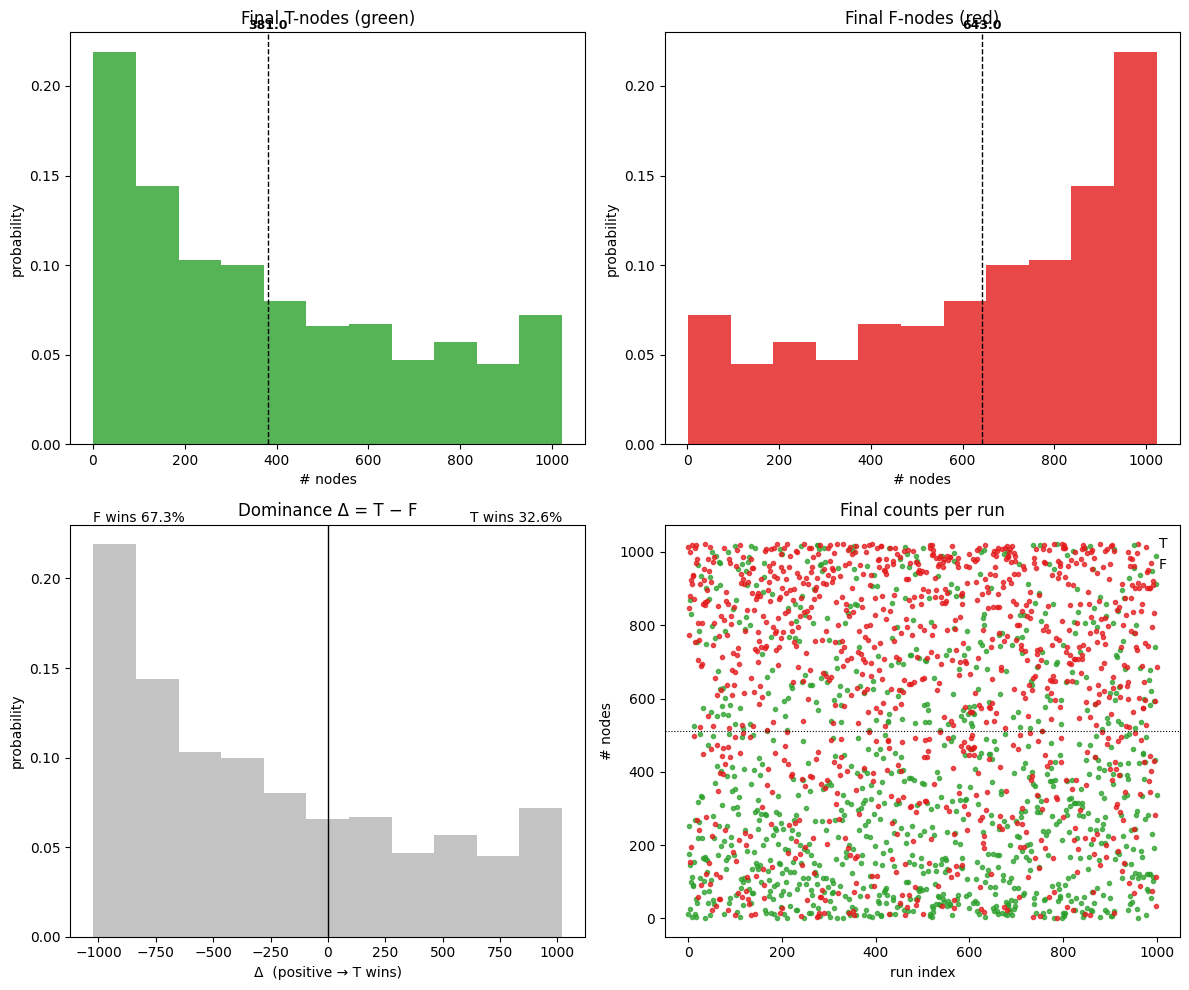

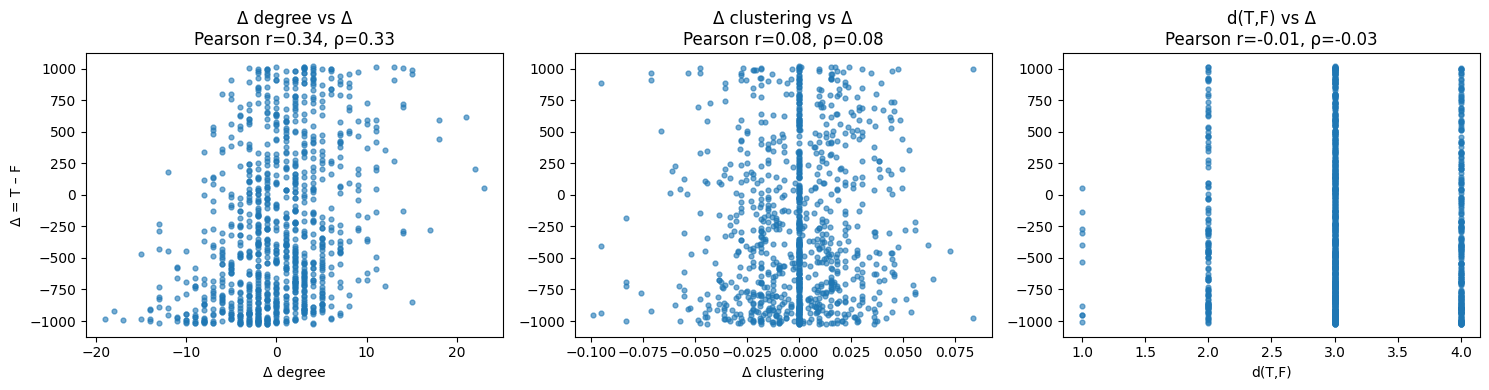

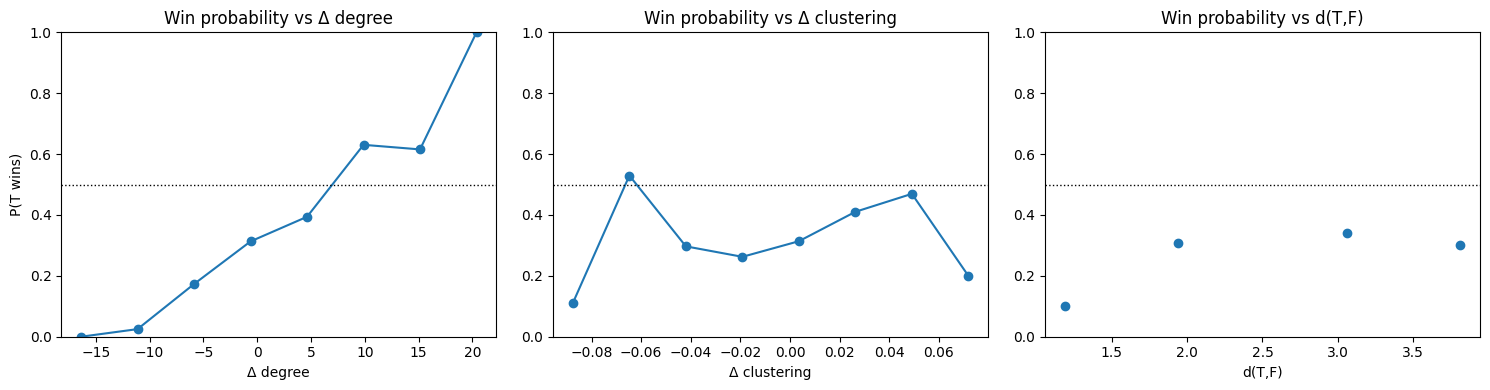

Finished – results in C:\Users\setia\Desktop\FOLDERS\CompNet project\report 3\batch_outputs


In [3]:
cfg = make_cfg(
    runs=1000,
    beta_T=0.35, beta_F=0.40,   # a bit higher helps
    maxsteps=200_000,           # bigger cap
    fixednet=True,
    force_finish=False, 
            show= True        # keep the cap in effect
)
run_batch(cfg)


─ Network diagnostics ─
  combined_overall: n=1024, m=4071, ⟨k⟩=7.95, C=0.136, L=3.763
     combined_blue: n=1024, m=2025, ⟨k⟩=3.96, C=0.480, L=32.402
      combined_red: n=1024, m=2023, ⟨k⟩=3.95, C=0.005, L=4.989
    combined_mixed: n=4, m=3, ⟨k⟩=1.50, C=0.000, L=1.667
 · 100/1000 runs done
 · 200/1000 runs done
 · 300/1000 runs done
 · 400/1000 runs done
 · 500/1000 runs done
 · 600/1000 runs done
 · 700/1000 runs done
 · 800/1000 runs done
 · 900/1000 runs done
 · 1000/1000 runs done
 Using 1000 finished runs for plots/statistics.


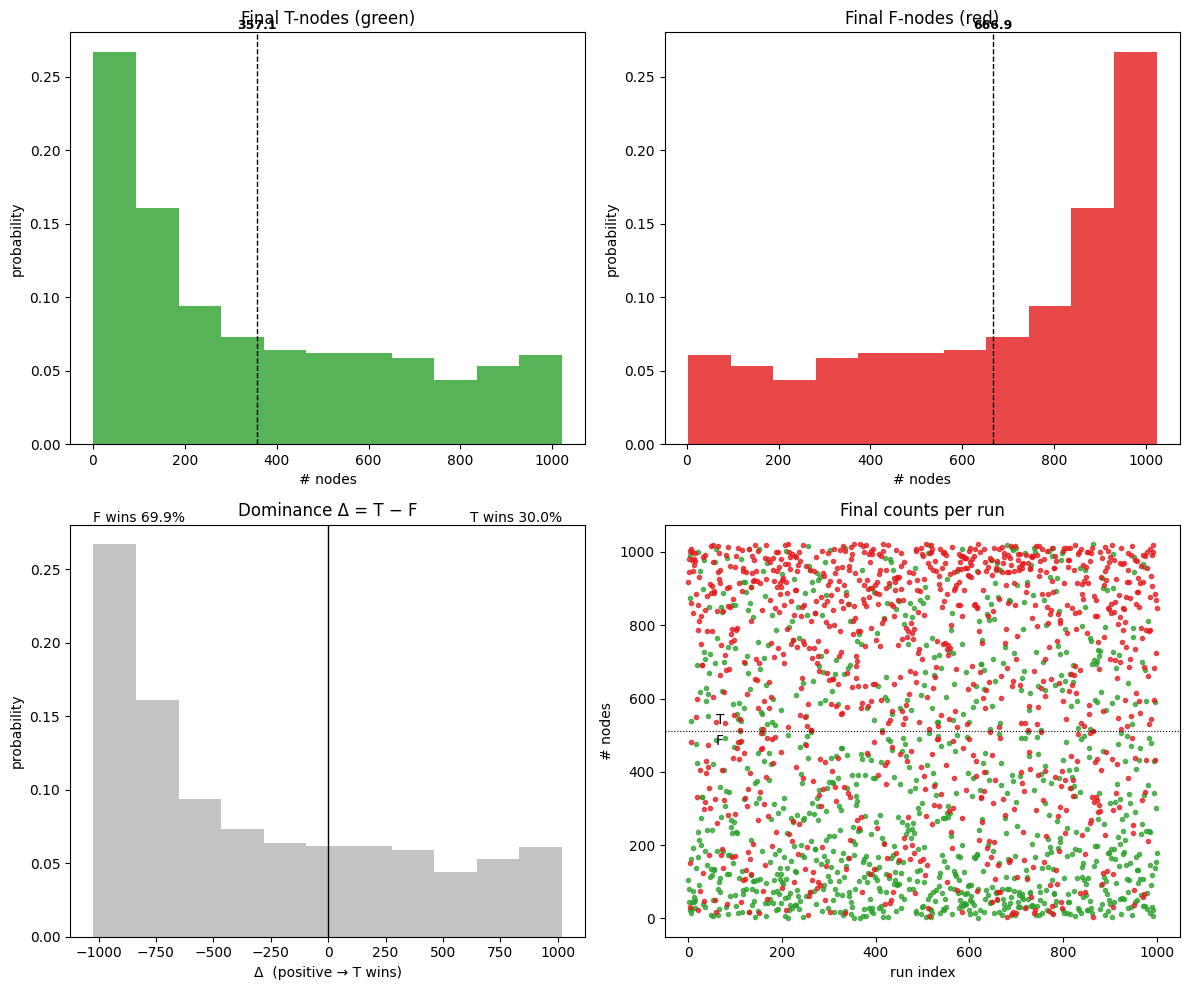

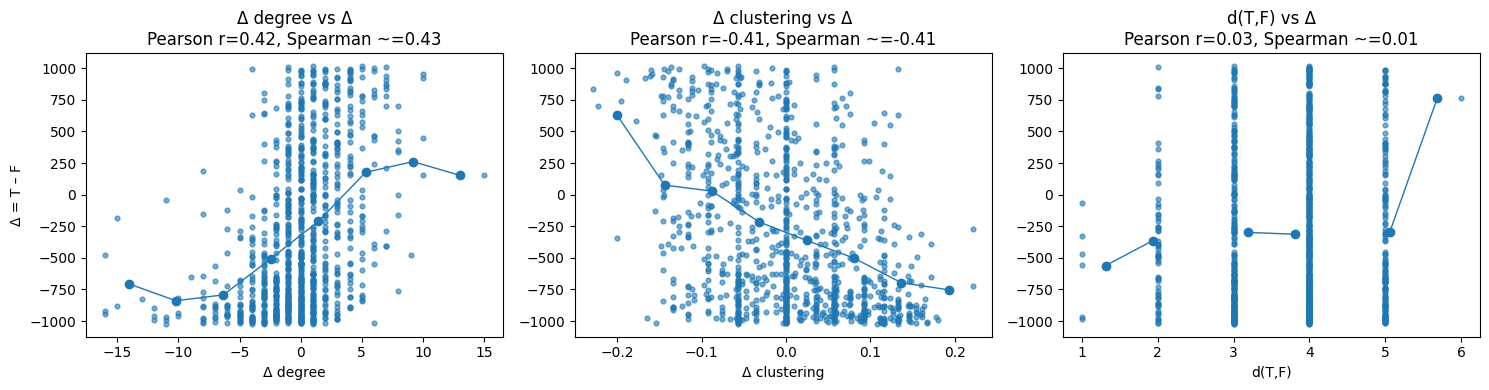

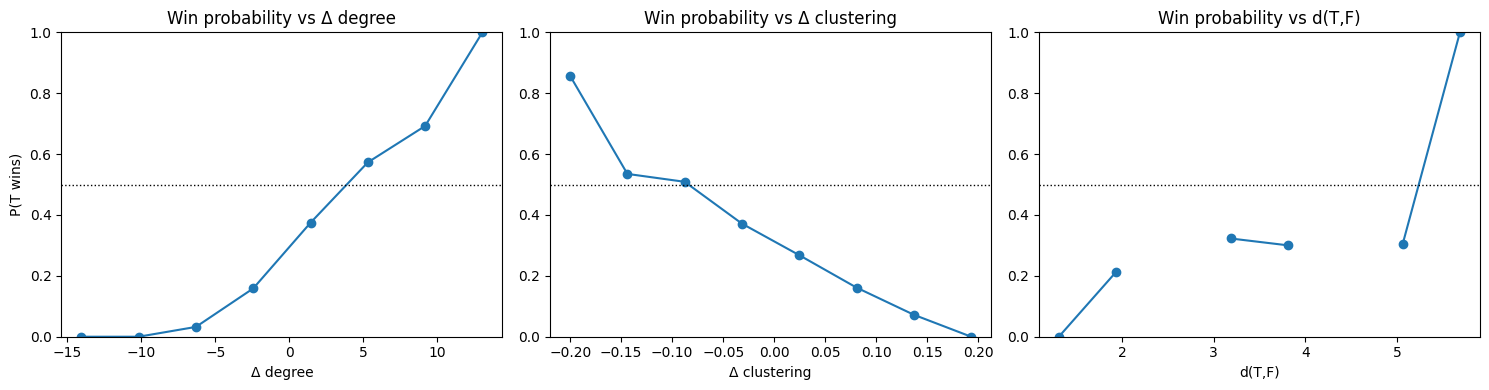

Finished – results in C:\Users\setia\Desktop\FOLDERS\CompNet project\report 3\batch_outputs


In [ ]:
from __future__ import annotations
import random, pathlib, json
from dataclasses import dataclass, asdict
from collections import Counter
from types import SimpleNamespace
from typing import Tuple, Dict, Optional

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


# ------------------------------ configuration -------------------------------

@dataclass
class Config:
    runs: int = 300
    L: int = 32
    beta_T: float = 0.30
    beta_F: float = 0.30
    # Blue layer
    p_rewire: float = 0.05
    k_blue: int = 6             # if blue_mode='grid_ws', must be 4
    blue_mode: str = 'ws_nx'    # 'ws_nx' | 'grid_ws'
    # Red (BA) layer
    m0_red: int = 4
    m_red: int = 3              # set 0 to disable BA layer entirely
    # Dynamics
    color_beta_multipliers: Dict[str, Tuple[float, float]] = None
    #   Multipliers for (beta_T, beta_F) per edge color; if None, all = (1.0, 1.0)
    #   Example: {'blue':(1.0, 0.7), 'red':(0.7, 1.0), 'mixed':(1.0, 1.0)}
    max_steps: int = 12_000
    force_finish: bool = False
    # Batch & IO
    seed: Optional[int] = 12345
    outdir: str = 'batch_outputs'
    show: bool = True
    fixednet: bool = True
    # Diagnostics
    print_diagnostics: bool = True


# --------------------------- network construction ----------------------------

def _grid_positions(L: int) -> Dict[int, Tuple[int, int]]:
    N = L * L
    return {i: (i % L, i // L) for i in range(N)}

def _build_blue_ws_nx(N: int, k: int, p: float, rng: random.Random) -> nx.Graph:
    # Degree-preserving WS on a ring; uses its own RNG -> seed by sampling from rng
    seed = rng.randrange(2**32 - 1)
    G = nx.watts_strogatz_graph(n=N, k=k, p=p, seed=seed)
    return G

def _build_blue_grid_ws(L: int, p: float, rng: random.Random) -> nx.Graph:
    """
    Start from a periodic L×L grid (degree 4) and rewire each edge (u,v) with prob p:
    remove (u,v) and connect u to a random w (≠u, no multiedge/self-loop), preserving
    total edge count. This mimics WS-like shortcuts on a 2D torus.
    NOTE: K fixed at 4 for this mode.
    """
    grid = nx.grid_2d_graph(L, L, periodic=True)
    mapping = {n: i for i, n in enumerate(grid.nodes())}
    G = nx.relabel_nodes(grid, mapping).copy()
    N = L * L

    for u, v in list(G.edges()):
        if rng.random() < p:
            # Remove edge, then reconnect 'u' to a random 'w' avoiding dup/self
            G.remove_edge(u, v)
            while True:
                w = rng.randrange(N)
                if w != u and not G.has_edge(u, w):
                    G.add_edge(u, w)
                    break
    return G

def _build_red_ba(N: int, m0: int, m: int, rng: random.Random) -> nx.Graph:
    """
    Linear preferential attachment via 'targets' list (degree-proportional sampling).
    If m == 0, returns an edgeless graph with N nodes (i.e., BA layer disabled).
    """
    red = nx.Graph()
    red.add_nodes_from(range(N))
    if m <= 0 or m0 <= 0:
        return red

    init = rng.sample(range(N), m0)
    for i in range(m0):
        for j in range(i + 1, m0):
            red.add_edge(init[i], init[j])

    targets = list(init)  # degree-proportional multiset
    for new in range(N):
        if new in init:
            continue
        chosen = set()
        while len(chosen) < m:
            t = rng.choice(targets)
            if t != new:
                chosen.add(t)
        for t in chosen:
            red.add_edge(new, t)
        targets.extend([new] * m)
    return red

def build_layers(cfg: Config, rng: random.Random) -> Tuple[nx.Graph, Dict[int, Tuple[int, int]]]:
    """
    Build multiplex graph with colored edges:
      - blue: WS layer (either ws_nx or grid_ws)
      - red:  BA layer (m_red edges per new node), can be disabled with m_red=0
    Final G = union; overlapping edges colored 'mixed'.
    """
    L = cfg.L
    N = L * L
    pos = _grid_positions(L)

    # --- Blue layer
    if cfg.blue_mode == 'ws_nx':
        blue = _build_blue_ws_nx(N, cfg.k_blue, cfg.p_rewire, rng)
    elif cfg.blue_mode == 'grid_ws':
        if cfg.k_blue != 4:
            raise ValueError("blue_mode='grid_ws' requires k_blue == 4 (grid degree).")
        blue = _build_blue_grid_ws(L, cfg.p_rewire, rng)
    else:
        raise ValueError("blue_mode must be 'ws_nx' or 'grid_ws'.")

    # --- Red layer (BA)
    red = _build_red_ba(N, cfg.m0_red, cfg.m_red, rng)

    # --- Merge with colors
    G = nx.Graph()
    G.add_nodes_from(range(N))

    for u, v in blue.edges():
        if u != v:
            G.add_edge(u, v, color='blue')

    for u, v in red.edges():
        if u == v:
            continue
        if G.has_edge(u, v):
            G[u][v]['color'] = 'mixed'
        else:
            G.add_edge(u, v, color='red')

    return G, pos


# ------------------------------ diagnostics ----------------------------------

def _largest_cc_subgraph(G: nx.Graph) -> nx.Graph:
    if G.number_of_nodes() == 0:
        return G
    if nx.is_connected(G):
        return G
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

def network_diagnostics(G: nx.Graph, label: str) -> Dict[str, float]:
    """
    Compute quick diagnostics on G (overall). Also on color-specific subgraphs if present.
    Returns a dict of metrics and prints a brief summary.
    """
    def stats(H: nx.Graph) -> Dict[str, float]:
        Hcc = _largest_cc_subgraph(H)
        n = Hcc.number_of_nodes()
        m = Hcc.number_of_edges()
        degs = [d for _, d in Hcc.degree()]
        kavg = float(np.mean(degs)) if degs else 0.0
        clus = float(nx.average_clustering(Hcc)) if n > 1 else 0.0
        try:
            aspl = float(nx.average_shortest_path_length(Hcc)) if n > 1 else float('nan')
        except Exception:
            aspl = float('nan')
        return dict(nodes=n, edges=m, k_avg=kavg, clustering=clus, aspl=aspl)

    # overall
    out = {f"{label}_overall": stats(G)}

    # by color
    for color in ['blue', 'red', 'mixed']:
        E = [(u, v) for u, v, a in G.edges(data=True) if a.get('color') == color]
        H = nx.Graph(); H.add_nodes_from(G.nodes()); H.add_edges_from(E)
        out[f"{label}_{color}"] = stats(H)

    return out

def print_diagnostics(diag: Dict[str, Dict[str, float]]):
    def fmt(d):
        return (f"n={d['nodes']}, m={d['edges']}, ⟨k⟩={d['k_avg']:.2f}, "
                f"C={d['clustering']:.3f}, L={d['aspl']:.3f}")
    print("─ Network diagnostics ─")
    for k, v in diag.items():
        print(f"{k:>18}: {fmt(v)}")


# ------------------------------ one realisation ------------------------------

def simulate_once(seed: int, *,
                  cfg: Config,
                  G_template: Optional[nx.Graph] = None,
                  pos: Optional[Dict[int, Tuple[int, int]]] = None) -> dict:
    rng = random.Random(seed)

    if G_template is None:
        G, pos = build_layers(cfg, rng)
    else:
        G = G_template

    N = len(G)
    state = {n: 'S' for n in G}
    pt_T, pt_F = rng.sample(range(N), 2)
    state[pt_T] = 'T'
    state[pt_F] = 'F'

    # Color-dependent betas (multipliers); default = (1,1) for all
    mults = cfg.color_beta_multipliers or {'blue': (1.0, 1.0),
                                           'red': (1.0, 1.0),
                                           'mixed': (1.0, 1.0)}
    def get_betas(edge_color: str) -> Tuple[float, float]:
        mT, mF = mults.get(edge_color, (1.0, 1.0))
        return cfg.beta_T * mT, cfg.beta_F * mF

    def count_S_T_F():
        c = Counter(state.values())
        return c['S'], c['T'], c['F']

    S, T, F = count_S_T_F()
    step = 0
    cap = float('inf') if cfg.force_finish else cfg.max_steps

    edges_list = list(G.edges())
    while S > 0 and step < cap:
        step += 1
        u, v = edges_list[rng.randrange(len(edges_list))]
        color = G[u][v].get('color', 'mixed')
        bT, bF = get_betas(color)

        # T tries
        if state[u] == 'T' and state[v] == 'S' and rng.random() < bT:
            state[v] = 'T'; S -= 1; T += 1
        elif state[v] == 'T' and state[u] == 'S' and rng.random() < bT:
            state[u] = 'T'; S -= 1; T += 1

        # F tries
        if state[u] == 'F' and state[v] == 'S' and rng.random() < bF:
            state[v] = 'F'; S -= 1; F += 1
        elif state[v] == 'F' and state[u] == 'S' and rng.random() < bF:
            state[u] = 'F'; S -= 1; F += 1

    deg_T = G.degree(pt_T); deg_F = G.degree(pt_F)
    cl_T = nx.clustering(G, pt_T); cl_F = nx.clustering(G, pt_F)
    dist_TF = nx.shortest_path_length(G, pt_T, pt_F)

    return dict(T=T, F=F,
                deg_T=deg_T, deg_F=deg_F,
                cl_T=cl_T, cl_F=cl_F,
                dist=dist_TF,
                finished=(S == 0))


# -------------------------------- batch driver -------------------------------

def make_cfg(**kwargs) -> Config:
    cfg = Config()
    for k, v in kwargs.items():
        setattr(cfg, k, v)
    return cfg

def run_batch(cfg: Config):
    outroot = pathlib.Path(cfg.outdir); outroot.mkdir(exist_ok=True)

    # build ONCE if fixednet=True (reused across all runs)
    fixedG, fixedPos = (None, None)
    if cfg.fixednet:
        base_seed = cfg.seed if cfg.seed is not None else random.randrange(2**32)
        fixedG, fixedPos = build_layers(cfg, random.Random(base_seed))
        if cfg.print_diagnostics:
            diag = network_diagnostics(fixedG, label="combined")
            print_diagnostics(diag)
    else:
        if cfg.print_diagnostics:
            # Build one temp graph to print typical stats
            gtmp, _ = build_layers(cfg, random.Random(cfg.seed or 0))
            diag = network_diagnostics(gtmp, label="combined")
            print_diagnostics(diag)

    results = []
    for i in range(cfg.runs):
        seed = (cfg.seed or random.randrange(2**32)) + i
        res = simulate_once(seed,
                            cfg=cfg,
                            G_template=fixedG,
                            pos=fixedPos)
        results.append(res)
        if (i + 1) % max(1, cfg.runs // 10) == 0:
            print(f" · {i + 1}/{cfg.runs} runs done", flush=True)

    # arrays
    N = cfg.L * cfg.L
    T_all = np.array([r['T'] for r in results])
    F_all = np.array([r['F'] for r in results])
    done = np.array([r['finished'] for r in results], dtype=bool)

    n_finished = int(done.sum())
    n_unfinished = int((~done).sum())
    if n_unfinished and not cfg.force_finish:
        print(f" ⚠ {n_unfinished}/{cfg.runs} runs hit max_steps before S=0.")

    # use finished runs if we have >=2; else fall back to all runs
    if n_finished >= 2:
        idx = done
        print(f" Using {n_finished} finished runs for plots/statistics.")
    else:
        idx = np.ones_like(done, dtype=bool)
        if not cfg.force_finish:
            print(" ⚠ Not enough finished runs → using ALL runs (T+F may be < N).")

    T = T_all[idx]
    F = F_all[idx]
    D = T - F

    deg_diff = np.array([r['deg_T'] - r['deg_F'] for r in results])[idx]
    cl_diff = np.array([r['cl_T'] - r['cl_F'] for r in results])[idx]
    dist_tf = np.array([r['dist'] for r in results])[idx]

    # safe correlations
    def safe_corr(x, y):
        x = np.asarray(x); y = np.asarray(y)
        if x.size < 2 or y.size < 2:
            return float('nan'), float('nan')
        try:
            r = float(pearsonr(x, y)[0])
        except Exception:
            r = float('nan')
        try:
            rs = float(spearmanr(x, y)[0])
        except Exception:
            rs = float('nan')
        return r, rs

    # ------------------------------ FIGURE 1 ---------------------------------
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    def hist_prob_with_mean(ax, data, color, title, xlabel, nbins='auto'):
        if data.size == 0:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('probability')
            return np.array([]), np.array([])
        weights = np.ones_like(data, dtype=float) / data.size
        edges = np.histogram_bin_edges(data, bins=nbins)
        vals, bins, _ = ax.hist(
            data, bins=edges, weights=weights, alpha=0.8,
            color=color, edgecolor='none'
        )
        m = float(np.mean(data))
        ax.axvline(m, color='k', ls='--', lw=1)
        ax.annotate(f'{m:.1f}', xy=(m, vals.max()*1.05), xytext=(0, 0),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('probability')
        return vals, bins

    hist_prob_with_mean(axs[0, 0], T, '#2ca02c', 'Final T-nodes (green)', '# nodes')
    hist_prob_with_mean(axs[0, 1], F, '#e41a1c', 'Final F-nodes (red)', '# nodes')

    # 2) Dominance Δ = T − F
    if D.size:
        weights_D = np.ones_like(D, dtype=float) / D.size
        edges_D = np.histogram_bin_edges(D, bins='auto')
        vals_D, bins_D, _ = axs[1, 0].hist(
            D, bins=edges_D, weights=weights_D,
            color='#bdbdbd', alpha=0.9, edgecolor='none'
        )
        axs[1, 0].axvline(0, color='k', lw=1)
        axs[1, 0].set_title('Dominance Δ = T − F')
        axs[1, 0].set_xlabel('Δ  (positive → T wins)')
        axs[1, 0].set_ylabel('probability')

        xL, xR = float(D.min()), float(D.max())
        yTop = float(vals_D.max()) * 1.05
        axs[1, 0].annotate(f'F wins {(D<0).mean()*100:.1f}%',
                           xy=(xL, yTop), xytext=(0, 0), textcoords='offset points',
                           ha='left', va='bottom')
        axs[1, 0].annotate(f'T wins {(D>0).mean()*100:.1f}%',
                           xy=(xR, yTop), xytext=(0, 0), textcoords='offset points',
                           ha='right', va='bottom')
    else:
        axs[1, 0].text(0.5, 0.5, 'no data', ha='center', va='center',
                       transform=axs[1, 0].transAxes)

    # dot plot (T green, F red)
    run_idx = np.arange(T.size)
    axs[1, 1].scatter(run_idx, T, s=9, alpha=0.75, color='#2ca02c', label='T')
    axs[1, 1].scatter(run_idx, F, s=9, alpha=0.75, color='#e41a1c', label='F')
    axs[1, 1].axhline((cfg.L * cfg.L) / 2, color='k', lw=0.8, ls=':')
    axs[1, 1].set_title('Final counts per run')
    axs[1, 1].set_xlabel('run index'); axs[1, 1].set_ylabel('# nodes')
    axs[1, 1].legend(loc='best', frameon=False)

    plt.tight_layout()
    fig.savefig(outroot / f"summary_plots_{cfg.runs}runs.png", dpi=300)
    if cfg.show:
        plt.show()
    plt.close(fig)

    # --- helpers for binned lines ---
    def _bin_means(x, y, nbins=8):
        x = np.asarray(x); y = np.asarray(y)
        if x.size == 0 or y.size == 0:
            return np.array([]), np.array([])
        edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins + 1)
        mids = 0.5 * (edges[:-1] + edges[1:])
        idx = np.digitize(x, edges[1:-1])  # 0..nbins-1
        means = np.full(nbins, np.nan)
        for k in range(nbins):
            sel = (idx == k)
            if np.any(sel):
                means[k] = np.nanmean(y[sel])
        return mids, means

    def _bin_winprob(x, d, nbins=8):
        x = np.asarray(x); d = np.asarray(d)
        if x.size == 0 or d.size == 0:
            return np.array([]), np.array([])
        edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins + 1)
        mids = 0.5 * (edges[:-1] + edges[1:])
        idx = np.digitize(x, edges[1:-1])
        p = np.full(nbins, np.nan)
        for k in range(nbins):
            sel = (idx == k)
            if np.any(sel):
                p[k] = np.mean(d[sel] > 0)
        return mids, p

    # --------------------------- FIGURE 2: seed effects ----------------------
    fig2, ax2 = plt.subplots(1, 3, figsize=(15, 4))
    for i, (arr, label) in enumerate([(deg_diff, 'Δ degree'),
                                      (cl_diff, 'Δ clustering'),
                                      (dist_tf, 'd(T,F)')]):
        ax2[i].scatter(arr, D, s=12, alpha=0.6)
        xm, ym = _bin_means(arr, D, nbins=8)
        if xm.size:
            ax2[i].plot(xm, ym, marker='o', lw=1)
        r, _ = safe_corr(arr, D)
        rs, _ = safe_corr(arr, np.argsort(np.argsort(D)))  # Spearman alt
        ax2[i].set_xlabel(label)
        if i == 0:
            ax2[i].set_ylabel('Δ = T – F')
        ax2[i].set_title(f'{label} vs Δ\nPearson r={r:.2f}, Spearman ~={rs:.2f}')

    plt.tight_layout()
    fig2.savefig(outroot / f"seed_effects_{cfg.runs}runs.png", dpi=300)
    if cfg.show:
        plt.show()
    plt.close(fig2)

    # ───────────────────────── FIGURE 3: win probability curves ──────────────
    fig3, ax3 = plt.subplots(1, 3, figsize=(15, 4))
    for i, (arr, label) in enumerate([(deg_diff, 'Δ degree'),
                                      (cl_diff, 'Δ clustering'),
                                      (dist_tf, 'd(T,F)')]):
        xm, p = _bin_winprob(arr, D, nbins=8)
        if xm.size:
            ax3[i].plot(xm, p, marker='o')
        ax3[i].axhline(0.5, color='k', ls=':', lw=1)
        ax3[i].set_ylim(0, 1)
        ax3[i].set_xlabel(label)
        if i == 0:
            ax3[i].set_ylabel('P(T wins)')
        ax3[i].set_title(f'Win probability vs {label}')
    plt.tight_layout()
    fig3.savefig(outroot / f"winprob_{cfg.runs}runs.png", dpi=300)
    if cfg.show:
        plt.show()
    plt.close(fig3)

    # JSON summary (matching the plotted subset)
    pear_deg, _ = safe_corr(deg_diff, D)
    pear_clust, _ = safe_corr(cl_diff, D)
    pear_dist, _ = safe_corr(dist_tf, D)

    with open(outroot / f"summary_{cfg.runs}runs.json", "w") as fh:
        json.dump({
            **asdict(cfg),
            "finished_runs": int(done.sum()),
            "unfinished_runs": int((~done).sum()),
            "used_finished_subset": bool(n_finished >= 2),
            "mean_T": float(np.mean(T)) if T.size else None,
            "std_T": float(np.std(T, ddof=1)) if T.size > 1 else None,
            "mean_F": float(np.mean(F)) if F.size else None,
            "std_F": float(np.std(F, ddof=1)) if F.size > 1 else None,
            "pearson_deg": pear_deg,
            "pearson_cl": pear_clust,
            "pearson_dist": pear_dist,
        }, fh, indent=2)

    for num in plt.get_fignums():
        fig = plt.figure(num)
        fig.savefig(outroot / f"figure_{num}_{cfg.runs}runs.png", dpi=300)
    print("Finished – results in", outroot.resolve())



if __name__ == "__main__":
    # Example 1: WS via networkx (degree = k_blue), BA enabled
    cfg = make_cfg(
        runs=1000,
        L=32,
        p_rewire=0.01,       # try 0.01 vs 0.05 and compare diagnostics + outcomes
        k_blue=4,            # valid for 'ws_nx'
        blue_mode='ws_nx',   # 'ws_nx' recommended to sweep k_blue & p independently
        m0_red=4,
        m_red=2,             # set 0 to disable BA
        beta_T=0.35,
        beta_F=0.40,
        # Example: make colors matter (T favored on blue, F on red)
        color_beta_multipliers={'blue': (1.00, 0.80),
                                'red': (0.80, 1.00),
                                'mixed': (1.00, 1.00)},
        max_steps=200_000,
        force_finish=False,
        seed=12345,
        outdir="batch_outputs",
        show=True,
        fixednet=True,
        print_diagnostics=True
    )
    run_batch(cfg)

